一、自己训练模型，采用逻辑回归算法，用于图片识别,准备环境 安装tensorflow 和 python: 
1、安装Python2.7和pip
Python2.7的官方网站：https://www.python.org/getit/
pip是Python Package Index，通过pip可以非常方便的查找安装其他软件，
2、安装pip的方法如下：https://pip.pypa.io/en/stable/installing/
3、安装TensorFlow
$ pip install tensorflow

In [91]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
import tensorflow as tf
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline


二、下载数据首先，我们会下载数据集到本地电脑；所有的图片都是28*28像素的图片，
标示为"A"到"J"（10个分类）。整个数据集合包含大概50000个训练数据和19000个测试数据，
所以这样规模的数据集合可以在大多数电脑上较快的完成训练。
训练数据文件名是notMNIST_large.tar.gz，测试数据文件名是notMNIST_small.tar.gz。

In [92]:
#2.对下载数据进行处理

#url = 'http://commondatastorage.googleapis.com/books1000/'
url = 'http://cn-static.udacity.com/mlnd/'

last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

#A hook to report the progress of a download. This is mostly intended for users with
#slow internet connections. Reports every 5% change in download progress.

def download_progress_hook(count, blockSize, totalSize):
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception('Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


In [93]:
#3.解压数据
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception('Expected %d folders, one per class. Found %d instead.' % (num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


In [94]:
#4.加载数据，验证数据集，查看一下A目录里面前20个数据图片
fn = os.listdir("notMNIST_small/F/")
for file in fn[:20]:
    path = 'notMNIST_small/F/' + file
    display(Image(path))

三、现在我们将要把图片数据转换成为像素，并且对数据进行Zero Mean是数据更加正则化，整个数据集会被加载到一个3D数组中（图片index，x，y）。
如果有些图片不能读取，我们就直接忽略掉。
由于可能不能一次性将所有数据读取到内存中，我们会对每个目录图片分别处理，并将处理完的数据存储到对应的pickle文件中。

In [95]:
# 5、将图片转换成像素 

image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),dtype=np.float32)
  print(folder)  

  num_images = 0
  #for image in image_files:

  #for image in image_files: 
  #由于内存不够，只能选择分批处理 
  print('Totol PIC Number=',len(image_files) )   
  for image in image_files[:5000]:
      
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
      #image_data = (plt.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
      #image_data = plt.imread(image_file)    
        
      if image_data.shape != (image_size, image_size):             
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' % (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

#train_datasets = maybe_pickle(train_folders, 45000)
train_datasets = maybe_pickle(train_folders, 4500)
test_datasets = maybe_pickle(test_folders, 1800)

./notMNIST_large/A.pickle already present - Skipping pickling.
./notMNIST_large/B.pickle already present - Skipping pickling.
./notMNIST_large/C.pickle already present - Skipping pickling.
./notMNIST_large/D.pickle already present - Skipping pickling.
./notMNIST_large/E.pickle already present - Skipping pickling.
./notMNIST_large/F.pickle already present - Skipping pickling.
./notMNIST_large/G.pickle already present - Skipping pickling.
./notMNIST_large/H.pickle already present - Skipping pickling.
./notMNIST_large/I.pickle already present - Skipping pickling.
./notMNIST_large/J.pickle already present - Skipping pickling.
./notMNIST_small/A.pickle already present - Skipping pickling.
./notMNIST_small/B.pickle already present - Skipping pickling.
./notMNIST_small/C.pickle already present - Skipping pickling.
./notMNIST_small/D.pickle already present - Skipping pickling.
./notMNIST_small/E.pickle already present - Skipping pickling.
./notMNIST_small/F.pickle already present - Skipping pi

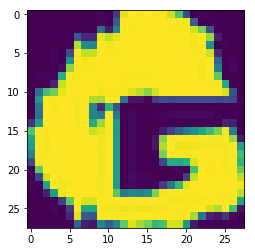

In [96]:
#6,验证图片质量，我们从*.pickle中随机挑选了一个数据
# index 0 should be all As, 1 = all Bs, etc.
pickle_file = train_datasets[6]   


# With would automatically close the file after the nested block of code
with open(pickle_file, 'rb') as f:
    
    # unpickle
    letter_set = pickle.load(f)  
    
    # pick a random image index
    sample_idx = np.random.randint(len(letter_set))
    
    # extract a 2D slice
    sample_image = letter_set[sample_idx, :, :]  
    plt.figure()
    
    # display it
    plt.imshow(sample_image)

四、准备训练数据、验证数据和测试数据
我们将pickle文件读取出来进行合并，生成了对应的训练数据（Training）,验证数据（Validation）和测试数据（Testin

In [97]:
#7、我们将pickle文件读取出来进行合并，生成了对应的训练数据（Training）,验证数据（Validation）和测试数据（Testing）。
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 20000
valid_size = 1000
test_size = 1000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
    train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (20000, 28, 28) (20000,)
Validation: (1000, 28, 28) (1000,)
Testing: (1000, 28, 28) (1000,)


In [98]:
#8、将数据随机排列
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

#9、将数据保存到notMNIST.pickle文件
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    


#10、去除数据集中重复的数据
       
import time

def check_overlaps(images1, images2):
    images1.flags.writeable=False
    images2.flags.writeable=False
    
    start = time.clock()
    
    #取两个数据集中的图片对象哈希值，并把他们放到两个集合中
    hash1 = set([hash(image1.data) for image1 in images1])
    hash2 = set([hash(image2.data) for image2 in images2])
    
    #取集合交集（目的为去除重复图片）
    all_overlaps = set.intersection(hash1, hash2)
    return all_overlaps, time.clock()-start

r, execTime = check_overlaps(train_dataset, test_dataset)    
print('Number of overlaps between training and test sets: {}. Execution time: {}.'.format(len(r), execTime))

r, execTime = check_overlaps(train_dataset, valid_dataset)   
print('Number of overlaps between training and validation sets: {}. Execution time: {}.'.format(len(r), execTime))

r, execTime = check_overlaps(valid_dataset, test_dataset) 
print('Number of overlaps between validation and test sets: {}. Execution time: {}.'.format(len(r), execTime))


五、训练模型，我们使用逻辑回归模型来进行训练，来看看最终的准确度如何？

In [102]:
#11、训练模型，训练结果：

samples, width, height = train_dataset.shape
X_train = np.reshape(train_dataset,(samples,width*height))
y_train = train_labels

# Prepare testing data
samples, width, height = test_dataset.shape
X_test = np.reshape(test_dataset,(samples,width*height))
y_test = test_labels

# Import
from sklearn.linear_model import LogisticRegression

# Instantiate
lg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42, verbose=1, max_iter=1000, n_jobs=-1)

# Fit
lg.fit(X_train, y_train)

# Predict
y_pred = lg.predict(X_test)

# Score
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred)

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.4min finished


0.891

总结：
1、样本的质量、数据量对预测的精度，起着决定性的作用。
2、由于内存的问题，只能将原来的样本缩小到 十分之一 。
3、后续我将设计分布式的架构 + GPU 方式来训练，提高效率和精度。